# Example modeling process

### Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model specific imports
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import (get_training_observations, 
                     get_training_labels, 
                     get_protein_proportions,
                     drop_empty_columns)

### Load training data and labels

In [2]:
x_train_raw_counts = get_training_observations()
x_train = get_protein_proportions(x_train_raw_counts)
print(f"There are {x_train.shape[1]} features")
y_train = get_training_labels()

Getting all training observations from 'metagenome_classification.db'...
There are 16306 features
Getting all training labels from 'metagenome_classification.db'...


In [3]:
x_train.head(10)

index,PF00001.19,PF00002.22,PF00003.20,PF00004.27,PF00005.25,PF00006.23,PF00007.20,PF00008.25,PF00009.25,PF00010.24,...,PF17216.1,PF17217.1,PF17218.1,PF17219.1,PF17220.1,PF17221.1,PF17222.1,PF17223.1,PF17224.1,PF17225.1
0,0.000004,6.092434e-07,0.000000,0.001285,0.021986,0.000809,0.0,0.000010,0.001546,6.092434e-07,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000010,0.000000e+00,0.000003,0.001523,0.015320,0.001126,0.0,0.000024,0.002005,3.392429e-06,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.000000e+00,0.000000,0.001595,0.011640,0.001008,0.0,0.000000,0.001650,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.000000e+00,0.000010,0.002188,0.018117,0.001597,0.0,0.000000,0.002543,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000002,0.000000e+00,0.000000,0.001786,0.014518,0.000924,0.0,0.000000,0.001915,3.916983e-06,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5,0.000012,1.197289e-05,0.000000,0.002706,0.008824,0.001257,0.0,0.000000,0.002155,0.000000e+00,...,0.000012,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
6,0.000000,0.000000e+00,0.000000,0.002233,0.013982,0.001488,0.0,0.000005,0.002459,5.383928e-06,...,0.000005,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
7,0.000000,0.000000e+00,0.000000,0.001661,0.018014,0.000828,0.0,0.000000,0.001876,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
8,0.005429,9.319447e-05,0.000047,0.001631,0.012302,0.000815,0.0,0.000396,0.001375,3.494793e-04,...,0.000000,0.000047,0.0,0.0,0.0,0.000023,0.0,0.0,0.0,0.0
9,0.000008,0.000000e+00,0.000000,0.002739,0.016584,0.001230,0.0,0.000000,0.002286,0.000000e+00,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [4]:
y_train.head()

index,EMPO_1,EMPO_2,EMPO_3
0,Host-associated,Plant,Plant rhizosphere
1,Free-living,Non-saline,Soil (non-saline)
2,Free-living,Saline,Water (saline)
3,Free-living,Non-saline,Water (non-saline)
4,Free-living,Non-saline,Soil (non-saline)


### Data manipulation
Validation splits, dimensionality reduction, etc

In [5]:
# convert string labels to numeric
labels3 = [
    'Aerosol (non-saline)',
    'Animal corpus',
    'Animal proximal gut',
    'Hypersaline (saline)',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Sediment (saline)',
    'Soil (non-saline)',
    'Subsurface (non-saline)',
    'Surface (non-saline)',
    'Surface (saline)',
    'Water (non-saline)',
    'Water (saline)'
]
labels3_map = {}
for i in range(0,len(labels3)):
    label = labels3[i]
    labels3_map[label] = i

y_train['EMPO_3_int'] = y_train['EMPO_3'].map(labels3_map)

In [6]:
# Split into train/validation if not CV
X_tr, X_val, Y_tr, Y_val = train_test_split(x_train, y_train, test_size=0.2) #, random_state=1)

# Dimensionality reduction?
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
svd.fit(X_tr)

new_x_train = svd.transform(X_tr)
new_x_val = svd.transform(X_val)


In [7]:
# convert string labels to numeric
#Y_tr['EMPO_3_int'] = Y_tr['EMPO_3'].map(labels3_map)
#Y_tr.head()
#Y_val['EMPO_3_int'] = Y_val['EMPO_3'].map(labels3_map)

### Model training

Training...
Epoch 1/20


2022-07-29 22:34:47.664116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


15/15 [==============================] - 3s 130ms/step - loss: 2.1035 - accuracy: 0.3515 - val_loss: 1.8954 - val_accuracy: 0.4300
Epoch 2/20
15/15 [==============================] - 1s 87ms/step - loss: 1.6483 - accuracy: 0.5539 - val_loss: 1.6426 - val_accuracy: 0.4800
Epoch 3/20
15/15 [==============================] - 1s 84ms/step - loss: 1.4250 - accuracy: 0.5495 - val_loss: 1.4515 - val_accuracy: 0.5600
Epoch 4/20
15/15 [==============================] - 1s 84ms/step - loss: 1.2761 - accuracy: 0.6296 - val_loss: 1.2717 - val_accuracy: 0.6900
Epoch 5/20
15/15 [==============================] - 1s 86ms/step - loss: 1.1864 - accuracy: 0.7052 - val_loss: 1.2011 - val_accuracy: 0.6400
Epoch 6/20
15/15 [==============================] - 1s 86ms/step - loss: 1.0844 - accuracy: 0.7186 - val_loss: 1.0948 - val_accuracy: 0.7400
Epoch 7/20
15/15 [==============================] - 1s 85ms/step - loss: 1.0126 - accuracy: 0.7464 - val_loss: 1.0445 - val_accuracy: 0.7700
Epoch 8/20
15/15 [=====

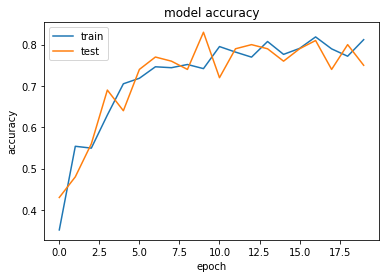

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 560)               9131920   
                                                                 
 dropout (Dropout)           (None, 560)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                8415      
                                                                 
Total params: 9,140,335
Trainable params: 9,140,335
Non-trainable params: 0
_________________________________________________________________


In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

def build_model(n_classes,
  hidden_layer_sizes=[],
  activation='relu',
  final_layer_activation='softmax',
  dropout=0.0,
  kernel_regularizer=1e-5,
  bias_regularizer=1e-5,
  activity_regularizer=1e-5,
  optimizer='Adam',
  learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)
  model = keras.Sequential()
  model.add(keras.layers.Flatten())

  for hidden_layer_size in hidden_layer_sizes:
        if hidden_layer_size > n_classes:
            model.add(keras.layers.Dense(
                hidden_layer_size,
                activation=activation,
                kernel_regularizer=keras.regularizers.L2(kernel_regularizer),
                bias_regularizer=keras.regularizers.L2(bias_regularizer),
                activity_regularizer=keras.regularizers.L2(activity_regularizer)
            ))
            if dropout > 0:
                model.add(keras.layers.Dropout(dropout))
  model.add(keras.layers.Dense(
        n_classes,
        activation=final_layer_activation,
        kernel_regularizer=keras.regularizers.L2(kernel_regularizer),
        bias_regularizer=keras.regularizers.L2(bias_regularizer),
        activity_regularizer=keras.regularizers.L2(activity_regularizer)
  ))
  opt = None
  if optimizer == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  else:
    raise f"Unsupported optimizer, {optimizer}"
  model.compile(loss='sparse_categorical_crossentropy', 
    optimizer=opt, metrics=['accuracy'])    
  return model

def train_model(X_train, Y_train, num_classes,
  hidden_layer_sizes=[],
  kernel_regularizer=0,
  bias_regularizer=0,
  activity_regularizer=0,
  activation='tanh',
  final_layer_activation='softmax',
  dropout=0.2,
  optimizer='Adam',
  learning_rate=0.01,
  batch_size=64,
  num_epochs=5):

  # Build the model.
  model = build_model(
        num_classes,
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        final_layer_activation=final_layer_activation,
        dropout=dropout,
        kernel_regularizer=1e-5,
        bias_regularizer=1e-5,
        activity_regularizer=1e-5,
        optimizer=optimizer,
        learning_rate=learning_rate)

  # Train the model.
  print('Training...')
  history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  model.summary()
  return model

# model with 1 hidden layers
nn1 = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[560],
    kernel_regularizer=3.59e-08,
    bias_regularizer=1.08e-05,
    activity_regularizer=5.98e-05,
    dropout=0.027,
    optimizer='Adam',
    learning_rate=0.009,
    batch_size=64,
    num_epochs=20)



Training...
Epoch 1/20
15/15 [==============================] - 5s 236ms/step - loss: 2.0586 - accuracy: 0.3070 - val_loss: 1.7797 - val_accuracy: 0.4100
Epoch 2/20
15/15 [==============================] - 3s 191ms/step - loss: 1.3808 - accuracy: 0.5528 - val_loss: 1.3350 - val_accuracy: 0.6200
Epoch 3/20
15/15 [==============================] - 2s 158ms/step - loss: 1.1675 - accuracy: 0.6085 - val_loss: 0.9893 - val_accuracy: 0.6400
Epoch 4/20
15/15 [==============================] - 2s 159ms/step - loss: 0.9118 - accuracy: 0.7386 - val_loss: 1.0510 - val_accuracy: 0.7000
Epoch 5/20
15/15 [==============================] - 2s 158ms/step - loss: 0.9400 - accuracy: 0.7397 - val_loss: 0.7735 - val_accuracy: 0.8100
Epoch 6/20
15/15 [==============================] - 2s 156ms/step - loss: 0.7692 - accuracy: 0.7853 - val_loss: 0.6856 - val_accuracy: 0.8500
Epoch 7/20
15/15 [==============================] - 2s 159ms/step - loss: 0.6616 - accuracy: 0.8198 - val_loss: 0.6400 - val_accuracy: 0

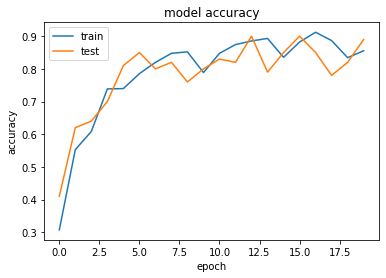

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 1011)              16486377  
                                                                 
 dropout (Dropout)           (None, 1011)              0         
                                                                 
 dense_1 (Dense)             (None, 993)               1004916   
                                                                 
 dropout_1 (Dropout)         (None, 993)               0         
                                                                 
 dense_2 (Dense)             (None, 15)                14910     
                                                                 
Total params: 17,506,203
Trainable params: 17,506,203
No

In [9]:
# model with 2 hidden layers
nn2 = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[1011, 993],
    kernel_regularizer=2.08e-07,
    bias_regularizer=8.18e-05,
    activity_regularizer=3.39e-06,
    dropout=0.009,
    optimizer='Adam',
    learning_rate=0.0036,
    batch_size=64,
    num_epochs=20)

Training...
Epoch 1/20
15/15 [==============================] - 4s 168ms/step - loss: 2.1338 - accuracy: 0.2636 - val_loss: 1.8936 - val_accuracy: 0.4600
Epoch 2/20
15/15 [==============================] - 2s 117ms/step - loss: 1.4991 - accuracy: 0.4805 - val_loss: 1.5693 - val_accuracy: 0.4100
Epoch 3/20
15/15 [==============================] - 2s 111ms/step - loss: 1.3059 - accuracy: 0.5584 - val_loss: 1.3287 - val_accuracy: 0.5700
Epoch 4/20
15/15 [==============================] - 2s 112ms/step - loss: 1.0744 - accuracy: 0.6474 - val_loss: 1.0044 - val_accuracy: 0.6400
Epoch 5/20
15/15 [==============================] - 2s 111ms/step - loss: 0.9435 - accuracy: 0.6919 - val_loss: 0.8854 - val_accuracy: 0.7300
Epoch 6/20
15/15 [==============================] - 2s 111ms/step - loss: 0.8138 - accuracy: 0.7653 - val_loss: 0.7253 - val_accuracy: 0.8200
Epoch 7/20
15/15 [==============================] - 2s 140ms/step - loss: 0.6547 - accuracy: 0.8031 - val_loss: 0.5708 - val_accuracy: 0

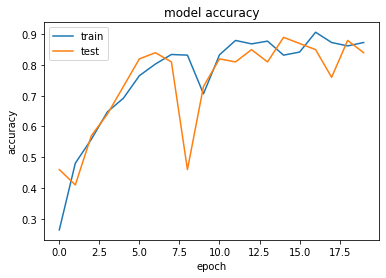

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 759)               12377013  
                                                                 
 dropout (Dropout)           (None, 759)               0         
                                                                 
 dense_1 (Dense)             (None, 148)               112480    
                                                                 
 dropout_1 (Dropout)         (None, 148)               0         
                                                                 
 dense_2 (Dense)             (None, 584)               87016     
                                                                 
 dropout_2 (Dropout)         (None, 584)               0

In [13]:
# model with 3 hidden layers
nn3 = train_model(X_tr, Y_tr['EMPO_3_int'], 15,
    hidden_layer_sizes=[759, 148, 584],
    kernel_regularizer=0,
    bias_regularizer=0,
    activity_regularizer=0,
    dropout=0.084,
    optimizer='Adam',
    learning_rate=0.0032,
    batch_size=64,
    num_epochs=20)

### Model evaluation

In [10]:
# Scoring model

nn2_accuracy = nn2.evaluate(x=X_val, y=Y_val['EMPO_3_int'], verbose=0, return_dict=True)['accuracy']
print(f"Accuracy of 2-layer NN on EMPO 3: {nn2_accuracy}")

Accuracy of 2-layer NN on EMPO 3: 0.8679999709129333


### Retrain best model
After experimenting with models, retrain your favorite model using entire training set (including validation) before saving

Training...
Epoch 1/20
18/18 [==============================] - 5s 222ms/step - loss: 2.0712 - accuracy: 0.2802 - val_loss: 1.5103 - val_accuracy: 0.5360
Epoch 2/20
18/18 [==============================] - 3s 154ms/step - loss: 1.2554 - accuracy: 0.5845 - val_loss: 1.1144 - val_accuracy: 0.6400
Epoch 3/20
18/18 [==============================] - 3s 154ms/step - loss: 0.8921 - accuracy: 0.7553 - val_loss: 0.7989 - val_accuracy: 0.7920
Epoch 4/20
18/18 [==============================] - 3s 159ms/step - loss: 0.7168 - accuracy: 0.8052 - val_loss: 0.8238 - val_accuracy: 0.8000
Epoch 5/20
18/18 [==============================] - 3s 158ms/step - loss: 0.6567 - accuracy: 0.8212 - val_loss: 0.8204 - val_accuracy: 0.7760
Epoch 6/20
18/18 [==============================] - 3s 183ms/step - loss: 0.5662 - accuracy: 0.8559 - val_loss: 0.7051 - val_accuracy: 0.8160
Epoch 7/20
18/18 [==============================] - 3s 158ms/step - loss: 0.5555 - accuracy: 0.8523 - val_loss: 0.5918 - val_accuracy: 0

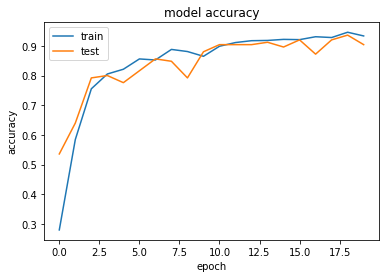

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16306)             0         
                                                                 
 dense (Dense)               (None, 1011)              16486377  
                                                                 
 dropout (Dropout)           (None, 1011)              0         
                                                                 
 dense_1 (Dense)             (None, 993)               1004916   
                                                                 
 dropout_1 (Dropout)         (None, 993)               0         
                                                                 
 dense_2 (Dense)             (None, 15)                14910     
                                                                 
Total params: 17,506,203
Trainable params: 17,506,203
No

In [11]:
import time

start_time = time.time()

final_nn = train_model(x_train, y_train['EMPO_3_int'], 15,
    hidden_layer_sizes=[1011, 993],
    kernel_regularizer=2.08e-07,
    bias_regularizer=8.18e-05,
    activity_regularizer=3.39e-06,
    dropout=0.009,
    optimizer='Adam',
    learning_rate=0.0036,
    batch_size=64,
    num_epochs=20)

end_time = time.time()
wallclock = int(end_time - start_time)
print(f"Wallclock = {wallclock} sec")

### Save fitted model

In [14]:
# Save best model as joblib or pkl file to 'model_joblibs' folder
from joblib import dump

dump(final_nn, '../model_joblibs/neural_network_EMPO3.joblib')

INFO:tensorflow:Assets written to: ram://f32331f2-60c0-467f-9384-cad8fb2f9ffb/assets


['../model_joblibs/neural_network_EMPO3.joblib']